# Import Statements

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import pickle
from sklearn.metrics import f1_score, accuracy_score
import torch.nn.functional as F
import numpy as np
import os
import re
import matplotlib.pyplot as plt

In [2]:
class EmotionDataset(Dataset):
    # Custom PyTorch Dataset for emotion classification.
    def __init__(self, data_path, vocab_path, label2id, max_len=50, token_col='Tokens', label_col='Emotion'):
        self.data = pd.read_pickle(data_path)
        
        # Load the tokenized dataset from pickle
        with open(vocab_path, 'rb') as f:
            self.vocab = pickle.load(f)

        # Store label-to-ID mapping and other parameters
        self.label2id = label2id
        self.token_col = token_col
        self.label_col = label_col
        self.max_len = max_len

    def __len__(self):
        # Return the total number of samples in the dataset.
        return len(self.data)

    def __getitem__(self, idx):
        #  Retrieve one data sample by index.

        # Retrieve the row corresponding to the given index
        row = self.data.iloc[idx]

        # Extract tokenized words and the emotion label
        tokens = row[self.token_col]
        label = row[self.label_col]

        # Convert tokens to corresponding IDs, using <UNK> for unknown tokens
        token_ids = [self.vocab.get(tok, self.vocab["<UNK>"]) for tok in tokens]
        # Truncate sequence if longer than max_len
        token_ids = token_ids[:self.max_len]
        # Pad sequence with <PAD> tokens if shorter than max_len
        token_ids += [self.vocab["<PAD>"]] * (self.max_len - len(token_ids))

        return torch.tensor(token_ids), torch.tensor(self.label2id[label])

In [3]:
# There are 7 emotions. Each emotion is associated to an id
label2id = {i: i for i in range(7)}

In [4]:
with open("../data/processed/vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

# Data loader

In [5]:
# Initialize training dataset
train_dataset = EmotionDataset(
    data_path="../data/processed/dd_train_tokenized.pkl",
    vocab_path="../data/processed/vocab.pkl",
    label2id=label2id,
    max_len=50,
    token_col="Tokens",
    label_col="Emotion"
)

# Create training dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize validation dataset
val_dataset = EmotionDataset(
    data_path="../data/processed/dd_val_tokenized.pkl",
    vocab_path="../data/processed/vocab.pkl",
    label2id=label2id,
    max_len=50,
    token_col="Tokens",
    label_col="Emotion"
)

# Create validation dataloader
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# Initialize testing dataset
test_dataset = EmotionDataset(
    data_path="../data/processed/dd_test_tokenized.pkl",
    vocab_path="../data/processed/vocab.pkl",
    label2id={i: i for i in range(7)},
    max_len=50,
    token_col="Tokens",
    label_col="Emotion"
)

# Create testing dataloader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# BiLSTM model

In [6]:
class BiLSTMEmotionClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, pad_idx):
        # Initialize BiLSTM-based emotion classifier model with embeddings, BiLSTM, 
        # dropout, and output layer.
        
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Forward pass embeds tokens, run through BiLSTM, average pooling, dropout, 
        # and output layer.
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        avg_pool = torch.mean(lstm_out, dim=1)
        dropped = self.dropout(avg_pool)
        output = self.fc(dropped)
        return self.softmax(output)

    def evaluate_loss(self, dataloader, device="cpu"):
        # Evaluate average loss of the model on a given dataloader 
        # without gradient updates.
        
        self.eval()
        criterion = nn.NLLLoss()
        total_loss, batches = 0.0, 0

        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                batches += 1

        return total_loss / max(batches, 1)

    
    def evaluate_model(self, dataloader, device="cpu"):
        # Calculate accuracy and macro-F1 score for the model on given dataloader.
        
        self.eval()
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self(inputs)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Compute metrics 
        acc = accuracy_score(all_labels, all_preds)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        return acc, macro_f1

    
    def fit(
        self,
        optimizer,
        criterion,
        train_loader,
        val_loader,
        epochs,
        lr,
        device="cpu",
        save_best_path="../models/checkpoints/emotion_classifer_best_weights.pt",
        save_last_path="../models/checkpoints/emotion_classifer_last_weights.pt"
    ):
        # Train the model for given epochs while saving best and last checkpoints.
        
        os.makedirs(os.path.dirname(save_best_path), exist_ok=True)
        os.makedirs(os.path.dirname(save_last_path), exist_ok=True)
    
        self.to(device)
        best_val_loss = float("inf")
        train_losses = []
        val_losses = []
    
        for epoch in range(epochs):
            self.train()
            total_loss, batches = 0.0, 0
    
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
    
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
    
                total_loss += loss.item()
                batches += 1
    
            train_loss = total_loss / max(batches, 1)
            val_loss = self.evaluate_loss(val_loader, device)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
    
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.state_dict(), save_best_path)
    
        torch.save(self.state_dict(), save_last_path)
    
        print("\nBest model saved!!\n")
        print("Training completed!\n")

        train_acc, train_macro_f1 = self.evaluate_model(train_loader, device)
        print(f"\nFinal Train Accuracy: {train_acc:.4f}")
        print(f"Final Train Macro F1: {train_macro_f1:.4f}")
        
        val_acc, val_macro_f1 = self.evaluate_model(val_loader, device)
        print(f"\nFinal Validation Accuracy: {val_acc:.4f}")
        print(f"Final Validation Macro F1: {val_macro_f1:.4f}")
    
        return train_losses, val_losses

    def plot_loss_curves(self, train_losses, val_losses, name):
        # Plot training and validation loss curves.
        
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"Train and Validation Loss Curve for {name}")
        plt.legend()
        plt.grid(True)
        plt.show()

    def emotion_predict(self, dataset):
        # Predict emotions for some sample utterances from the test dataset
        # to see the performance of the model
        
        id2label = {
            0: 'no emotion', 1: 'anger', 2: 'disgust', 3: 'fear',
            4: 'happiness', 5: 'sadness', 6: 'surprise'
        }
        index = [5778, 2891, 4384, 5660, 4268, 4133, 149, 5497]
        
        for i in index:
            row = dataset.data.iloc[i]
            text = row["Utterance"]
        
            input_ids, label = dataset[i]
            input_ids = input_ids.unsqueeze(0).to(device)
        
            with torch.no_grad():
                output = self(input_ids)
                pred = torch.argmax(output, dim=1).item()
        
            print("Utterance:", text)
            print("True:", id2label[int(label.item())], "| Predicted:", id2label[pred])
            print()

In [7]:
vocab_size = len(vocab)
embed_dimen = 128
hidden_dimen = 64
output_dimen = len(label2id)
pad_idxx = vocab["<PAD>"]
epochs = 10
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Initialise the model, optimizer and criterion
model = BiLSTMEmotionClassifier(
    vocab_size = vocab_size, 
    embed_dim = embed_dimen, 
    hidden_dim = hidden_dimen, 
    output_dim = output_dimen, 
    pad_idx = pad_idxx)

optimizer = torch.optim.Adam(model.parameters(), lr)
criterion = nn.NLLLoss()

# Model Training

In [9]:
# Train the model
ckpt_dir = "../models/checkpoints/emotion_classifier/tuning"
best_ckpt = os.path.join(ckpt_dir, "emotion_classifier_best.pt")
last_ckpt = os.path.join(ckpt_dir, "emotion_classifier_last.pt")

train_losses, val_losses = model.fit(
    optimizer,
    criterion,
    train_loader,
    val_loader,
    epochs,
    lr,
    device=device,
    save_best_path=best_ckpt,
    save_last_path=last_ckpt
)

Epoch 1/10 | Train Loss: 0.5899 | Val Loss: 0.4023
Epoch 2/10 | Train Loss: 0.5282 | Val Loss: 0.3864
Epoch 3/10 | Train Loss: 0.4935 | Val Loss: 0.3720
Epoch 4/10 | Train Loss: 0.4665 | Val Loss: 0.3627
Epoch 5/10 | Train Loss: 0.4394 | Val Loss: 0.3518
Epoch 6/10 | Train Loss: 0.4203 | Val Loss: 0.3453
Epoch 7/10 | Train Loss: 0.3988 | Val Loss: 0.3465
Epoch 8/10 | Train Loss: 0.3785 | Val Loss: 0.3451
Epoch 9/10 | Train Loss: 0.3570 | Val Loss: 0.3512
Epoch 10/10 | Train Loss: 0.3360 | Val Loss: 0.3542

Best model saved!!

Training completed!


Final Train Accuracy: 0.9021
Final Train Macro F1: 0.4414

Final Validation Accuracy: 0.8906
Final Validation Macro F1: 0.3028


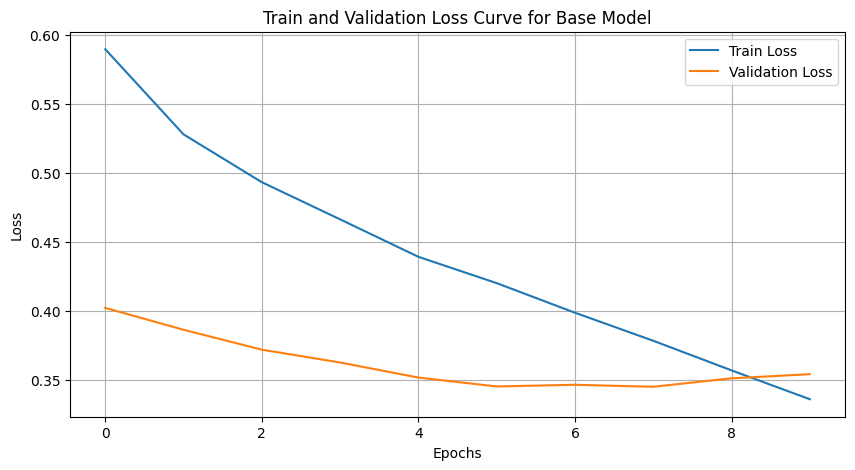

In [10]:
# Plot the loss curve
model.plot_loss_curves(train_losses, val_losses, "Base Model")

# Testing the model

In [11]:
test_acc, test_macro_f1 = model.evaluate_model(test_loader, device)
print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Final Test Macro F1: {test_macro_f1:.4f}")

Final Test Accuracy: 0.8328
Final Test Macro F1: 0.2803


# Check predictions

In [12]:
model.emotion_predict(test_dataset)

Utterance:  How many credits for each course ? 
True: no emotion | Predicted: no emotion

Utterance:  Wow , it's surprising . So what do I get ? 
True: surprise | Predicted: surprise

Utterance:  Promise that you won't get angry . 
True: fear | Predicted: no emotion

Utterance:  Wow , fantastic . I like the font and color for his name . It is creative yet personal . 
True: happiness | Predicted: happiness

Utterance: It's beautiful here . 
True: happiness | Predicted: happiness

Utterance: I am sorry to have kept all of you waiting . I was delayed by something urgent . 
True: sadness | Predicted: no emotion

Utterance:  We're sorry that this has happened , and I guarantee that the same mistake won't happen again . 
True: no emotion | Predicted: no emotion

Utterance:  Yes , it is annoying . 
True: anger | Predicted: no emotion



# Hyper parameter tuning

In [13]:
hyper_parameter_variants = [
    {"embed_dim": 100, 
     "hidden_dim": 128, 
     "optim": "AdamW",
     "lr": 2e-3, 
     "epochs": 10},
    
    {"embed_dim": 128, 
     "hidden_dim": 256, 
     "optim": "AdamW", 
     "lr": 1.5e-3, 
     "epochs": 10},
]

def fine_tune_model(variants):
    # Train and evaluate the BiLSTMEmotionClassifier for multiple hyperparameter configurations.
    i = 1
    for variant in variants:
        print(f"Training the model with parameters: {variant}")
        print()
        model = BiLSTMEmotionClassifier(
            vocab_size = vocab_size, 
            embed_dim = variant["embed_dim"], 
            hidden_dim = variant["hidden_dim"], 
            output_dim = output_dimen, 
            pad_idx = pad_idxx)
        
        if variant["optim"] == "Adam":
            optimizer = torch.optim.Adam(model.parameters(), lr)

        elif variant["optim"] == "AdamW":
            optimizer = torch.optim.AdamW(model.parameters(), lr)

        variant_best_ckpt = os.path.join(ckpt_dir, f"emotion_classifier_best_variant{i}.pt")
        variant_last_ckpt = os.path.join(ckpt_dir, f"emotion_classifier_last_variant{i}.pt")

        train_losses, val_losses = model.fit(
            optimizer,
            criterion,
            train_loader,
            val_loader,
            variant["epochs"],
            variant["lr"],
            device=device,
            save_best_path=variant_best_ckpt,
            save_last_path=variant_last_ckpt
        )
        print()
        test_acc, test_macro_f1 = model.evaluate_model(test_loader, device)
        print(f"Final Test Accuracy: {test_acc:.4f}")
        print(f"Final Test Macro F1: {test_macro_f1:.4f}")

        model.plot_loss_curves(train_losses, val_losses, f"Model variant{i}")

        print("Emotion predictions for the model variant:")
        model.emotion_predict(test_dataset)
        i += 1
        print()

Training the model with parameters: {'embed_dim': 100, 'hidden_dim': 128, 'optim': 'AdamW', 'lr': 0.002, 'epochs': 10}

Epoch 1/10 | Train Loss: 0.5537 | Val Loss: 0.3759
Epoch 2/10 | Train Loss: 0.4787 | Val Loss: 0.3448
Epoch 3/10 | Train Loss: 0.4422 | Val Loss: 0.3360
Epoch 4/10 | Train Loss: 0.4117 | Val Loss: 0.3387
Epoch 5/10 | Train Loss: 0.3822 | Val Loss: 0.3408
Epoch 6/10 | Train Loss: 0.3559 | Val Loss: 0.3392
Epoch 7/10 | Train Loss: 0.3302 | Val Loss: 0.3415
Epoch 8/10 | Train Loss: 0.3059 | Val Loss: 0.3629
Epoch 9/10 | Train Loss: 0.2840 | Val Loss: 0.3776
Epoch 10/10 | Train Loss: 0.2666 | Val Loss: 0.3873

Best model saved!!

Training completed!


Final Train Accuracy: 0.9266
Final Train Macro F1: 0.5821

Final Validation Accuracy: 0.8842
Final Validation Macro F1: 0.3380

Final Test Accuracy: 0.8252
Final Test Macro F1: 0.3277


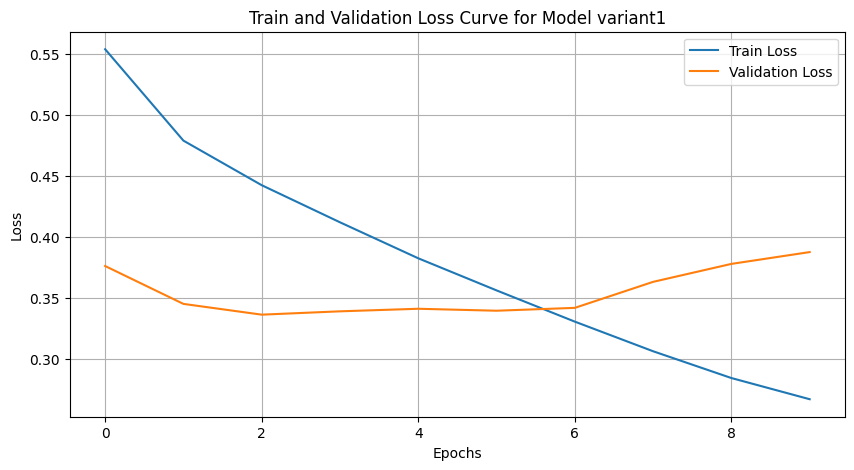

Emotion predictions for the model variant:
Utterance:  How many credits for each course ? 
True: no emotion | Predicted: no emotion

Utterance:  Wow , it's surprising . So what do I get ? 
True: surprise | Predicted: happiness

Utterance:  Promise that you won't get angry . 
True: fear | Predicted: no emotion

Utterance:  Wow , fantastic . I like the font and color for his name . It is creative yet personal . 
True: happiness | Predicted: happiness

Utterance: It's beautiful here . 
True: happiness | Predicted: happiness

Utterance: I am sorry to have kept all of you waiting . I was delayed by something urgent . 
True: sadness | Predicted: no emotion

Utterance:  We're sorry that this has happened , and I guarantee that the same mistake won't happen again . 
True: no emotion | Predicted: sadness

Utterance:  Yes , it is annoying . 
True: anger | Predicted: no emotion


Training the model with parameters: {'embed_dim': 128, 'hidden_dim': 256, 'optim': 'AdamW', 'lr': 0.0015, 'epochs': 10

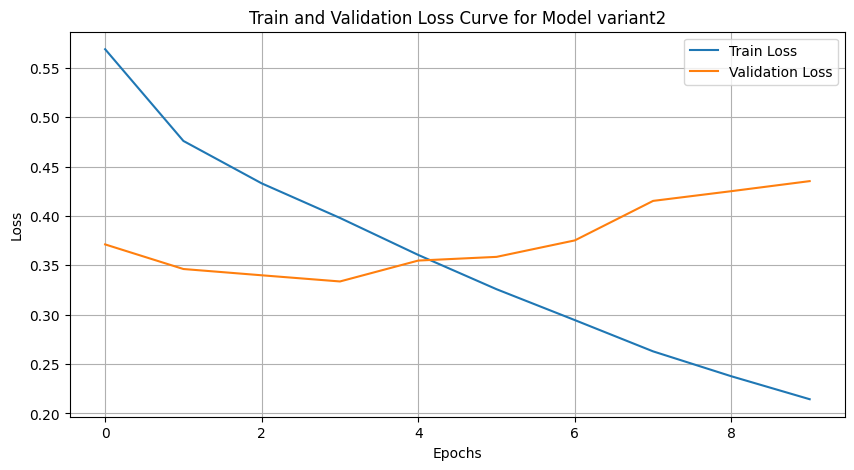

Emotion predictions for the model variant:
Utterance:  How many credits for each course ? 
True: no emotion | Predicted: no emotion

Utterance:  Wow , it's surprising . So what do I get ? 
True: surprise | Predicted: surprise

Utterance:  Promise that you won't get angry . 
True: fear | Predicted: no emotion

Utterance:  Wow , fantastic . I like the font and color for his name . It is creative yet personal . 
True: happiness | Predicted: no emotion

Utterance: It's beautiful here . 
True: happiness | Predicted: happiness

Utterance: I am sorry to have kept all of you waiting . I was delayed by something urgent . 
True: sadness | Predicted: no emotion

Utterance:  We're sorry that this has happened , and I guarantee that the same mistake won't happen again . 
True: no emotion | Predicted: no emotion

Utterance:  Yes , it is annoying . 
True: anger | Predicted: no emotion




In [14]:
fine_tune_model(hyper_parameter_variants)

Analysis:
 - The base model is showing a test accuracy of 83.28% and a Macro F1 score of 0.2803
 - The hyper parameter variant 1 model is showing a test accuracy of 82.52% and a Macro F1 score of 0.3277
 - The hyper parameter variant 2 model is showing a test accuracy of 83.49% and a Macro F1 score of 0.3674
 - The hyper parameter tuning has worked to improve the base performance of the dialogue act classifier model.
 - Even though the model with hyper parameter variant 2 is having better accuracy and Macro F1 Score, the base variant model is performing better in terms of emotion predictions.
 - Hence considering the base model for emotion classification.